### Raport: Implementacja algorytmu Minimax z cięciami alfa-beta dla gry Clobber ###

### 1. Wprowadzenie ###


### 2. Opis teoretyczny metody ###

### 3. Formalne sformułowanie problemu ###

3.1. Opis gry Clobber
Clobber to gra planszowa dla dwóch graczy rozgrywana na szachownicy o wymiarach n×m (standardowo 5×6). Na początku gry plansza jest całkowicie pokryta pionkami: czarne na czarnych polach, białe na białych. Grę rozpoczyna gracz czarny. Gracze wykonują ruchy naprzemiennie według następujących zasad:

Ruch polega na przesunięciu swojego pionka na sąsiednie pole (w pionie lub poziomie), które jest zajmowane przez pionek przeciwnika.
Pionek przeciwnika zostaje zbity i usunięty z planszy.
Gracz wygrywa, gdy przeciwnik nie może wykonać żadnego ruchu.

3.2. Formalna definicja problemu
Formalnie problem można zdefiniować jako:

Stan gry: Reprezentacja planszy Clobber o wymiarach n×m, gdzie każde pole może być puste, zawierać pionek gracza pierwszego (B) lub pionek gracza drugiego (W).
Akcje: Zbiór wszystkich legalnych ruchów dostępnych dla aktualnego gracza w danym stanie.
Model przejścia: Funkcja, która dla danego stanu i akcji zwraca nowy stan powstały po wykonaniu tej akcji.
Test końca gry: Predykat sprawdzający, czy dany stan jest stanem końcowym (żaden gracz nie może wykonać ruchu).
Funkcja użyteczności: Wartość liczbowa przypisana stanom końcowym (1 dla wygranej gracza pierwszego, -1 dla wygranej gracza drugiego).
Funkcja heurystyczna: Funkcja oceniająca korzystność stanów nieterminalnych dla aktualnego gracza.



3.3. Ograniczenia
Problem przeszukiwania drzewa gry dla Clobber podlega następującym ograniczeniom:

Złożoność obliczeniowa: Liczba możliwych stanów rośnie wykładniczo z głębokością przeszukiwania.
Ograniczenia czasowe: Ze względu na złożoność obliczeniową, głębokość przeszukiwania musi być ograniczona.
Jakość heurystyki: Efektywność algorytmu silnie zależy od trafności funkcji heurystycznej.



### 4. Opis implementacji ###

4.3. Funkcje heurystyczne
W projekcie zastosowano wzorzec projektowy strategii, implementując abstrakcyjną klasę bazową ClobberHeuristic i dziedziczące po niej konkretne funkcje heurystyczne:
pythonclass ClobberHeuristic(ABC):
    """Interface"""
    @abstractmethod
    def evaluate(self, game, player):
        pass
Zaimplementowano pięć różnych strategii heurystycznych:

4.3.1. MobilityDifferenceHeuristic - Różnica mobilności
Ta strategia opiera się na różnicy między liczbą dostępnych ruchów dla gracza a liczbą dostępnych ruchów dla przeciwnika.


pythonclass MobilityDifferenceHeuristic(ClobberHeuristic):
    """Difference in mobility between players"""
    def evaluate(self, game, player):
        opponent = 'W' if player == 'B' else 'B'
        player_moves = len(game.get_possible_moves(player))
        opponent_moves = len(game.get_possible_moves(opponent))
        return player_moves - opponent_moves

4.3.2. PieceMobilityHeuristic - Liczba mobilnych pionków
Ta strategia ocenia liczbę pionków, które mogą wykonać ruch.
pythonclass PieceMobilityHeuristic(ClobberHeuristic):
    """Heuristics based on the number of mobile pieces"""
    def evaluate(self, game, player):
        mobile_pieces = set()
        for move in game.get_possible_moves(player):
            x1, y1, _, _ = move
            mobile_pieces.add((x1, y1))
        return len(mobile_pieces)

4.3.3. CenterControlHeuristic - Kontrola centrum
Ta strategia faworyzuje kontrolę centrum planszy, przyznając więcej punktów za pionki znajdujące się bliżej środka.
pythonclass CenterControlHeuristic(ClobberHeuristic):
    """Heuristics based on the control of the center positions"""
    def evaluate(self, game, player):
        center_i, center_j = game.size[0] // 2, game.size[1] // 2
        score = 0
        opponent = 'W' if player == 'B' else 'B'

        for i in range(game.size[0]):
            for j in range(game.size[1]):
                if game.board[i, j] == player:
                    # Odległość od centrum
                    distance = abs(i - center_i) + abs(j - center_j)
                    score += (game.size[0] + game.size[1]) - distance
                elif game.board[i, j] == opponent:
                    distance = abs(i - center_i) + abs(j - center_j)
                    score -= (game.size[0] + game.size[1]) - distance

        return score

4.3.4. AdjacentOpponentHeuristic - Sąsiadujące pionki przeciwnika
Ta strategia ocenia liczbę pionków przeciwnika, które sąsiadują z pionkami gracza, czyli potencjalne cele do zbicia.
pythonclass AdjacentOpponentHeuristic(ClobberHeuristic):
    """Heuristics based on the number of adjacent opponent pieces"""
    def evaluate(self, game, player):
        opponent = 'W' if player == 'B' else 'B'
        score = 0
        directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]

        for i in range(game.size[0]):
            for j in range(game.size[1]):
                if game.board[i, j] == player:
                    # Sprawdzenie sąsiednich pozycji w poszukiwaniu pionków przeciwnika
                    for di, dj in directions:
                        ni, nj = i + di, j + dj
                        if (0 <= ni < game.size[0] and 0 <= nj < game.size[1] and
                                game.board[ni, nj] == opponent):
                            score += 1

        return score

4.4. Implementacja agenta Minimax
Agent Minimax jest zaimplementowany w klasie MinimaxAgent

### 5. Agent Adaptacyjny ###

Agent adaptacyjny wybiera heurystykę na podstawie:

1. Fazy gry (wczesna, środkowa, końcowa) określanej przez zapełnienie planszy
2. Analizy wzorców ruchów przeciwnika, klasyfikowanych jako:

    Agresywne (zwiększające liczbę możliwości zbicia)
    Defensywne (zmniejszające liczbę zagrożonych pionków)
    Centralne (skupione na kontroli centrum)

Agent adaptacyjny zaimplementowany jest w pliku MinimaxAgent.py w klasie AdaptiveMinimaxAgent

### 6. Przykład działania algorytmu ###

### 7. Implementacja głównej funkcji rozgrywki ###

Funkcja play_game w module Clobber.py umożliwia przeprowadzenie pełnej rozgrywki między dwoma agentami oraz zbieranie statystyk:


def play_game(agent1, agent2, initial_board=None, size=(5, 6), max_rounds=100, silent=False):
    """
    Przeprowadzenie pełnej rozgrywki między dwoma agentami.

    Argumenty:
        agent1: Agent dla gracza 1 (czarny).
        agent2: Agent dla gracza 2 (biały).
        initial_board: Opcjonalna początkowa plansza.
        size: Rozmiar planszy.
        max_rounds: Maksymalna liczba rund, aby zapobiec nieskończonym grom.
        silent: Czy wyłączyć wyświetlanie informacji na konsoli.

    Zwraca:
        krotka: (final_game, result_dict) gdzie result_dict zawiera statystyki
    """
    game = ClobberGame(initial_board, size)
    current_player = 'B'  # Czarny zaczyna
    rounds = 0

    # Śledzenie statystyk
    total_nodes_black = 0
    total_nodes_white = 0
    total_time_black = 0
    total_time_white = 0

    if not silent:
        print("Start Board:")
        game.print_board()
        print()

    while not game.is_game_over() and rounds < max_rounds:
        if current_player == 'B':
            rounds += 1
            if not silent:
                print(f"Round {rounds}:")

        if not silent:
            print(f"Player's move: {current_player}")

        # Wybór ruchu
        if current_player == 'B':
            start_time = time.time()
            move = agent1.get_move(game)
            end_time = time.time()

            nodes = agent1.nodes_visited
            elapsed = end_time - start_time

            # Aktualizacja statystyk
            total_nodes_black += nodes
            total_time_black += elapsed

            # Rejestracja ruchu dla adaptacyjnego agenta
            if isinstance(agent2, AdaptiveMinimaxAgent):
                agent2.register_opponent_move(move)

        else:  # current_player == 'W'
            start_time = time.time()
            move = agent2.get_move(game)
            end_time = time.time()

            nodes = agent2.nodes_visited
            elapsed = end_time - start_time

            # Aktualizacja statystyk
            total_nodes_white += nodes
            total_time_white += elapsed

            # Rejestracja ruchu dla adaptacyjnego agenta
            if isinstance(agent1, AdaptiveMinimaxAgent):
                agent1.register_opponent_move(move)

        # Wykonanie ruchu
        game = game.make_move(move)

        # Zmiana gracza
        current_player = 'W' if current_player == 'B' else 'B'

    # Określenie zwycięzcy
    winner = 'W' if current_player == 'B' else 'B'  # Gracz, który wykonał ostatni ruch

    # Utworzenie słownika z wynikami
    result = {
        "winner": winner,
        "rounds": rounds,
        "nodes_black": total_nodes_black,
        "nodes_white": total_nodes_white,
        "time_black": total_time_black,
        "time_white": total_time_white
    }

    return game, result

### 8. Wykorzystane materiały i biblioteki ###

8.1. Materiały źródłowe

Lista zadań "Sztuczna inteligencja i inżynieria wiedzy, Lista 2"
Wykłady
Dokumentacja zasad gry Clobber dostępna online

8.2. Wykorzystane biblioteki

Python 3.8+ - język implementacji
NumPy - do efektywnych operacji na tablicach 2D reprezentujących planszę
time - do pomiaru czasu wykonania algorytmu
copy - do tworzenia głębokich kopii stanów gry
abc - do tworzenia abstrakcyjnych klas bazowych dla heurystyk

### 9. Podsumowanie i napotkane problemy ###

9.1 Co dało nam Alpha-Beta pruning?



Gołym okiem widać ile daje cięcie alfa-beta. Nie wykonywałem testów dla max_depth=4 , ponieważ czas wykonania byłby zbyt długi. Widać, że przy max_depth=3 czas wykonania wzrasta wykładniczo, a przy max_depth=2 jest to już całkiem znośny czas.

Wykonałem test dla max_depth=4 i 5, ale tylko z włączonym cięciem alfa-beta.

  max_depth=4
        Nodes visited:3622174
        Time elapsed:142.60081601142883 s
        Average Time elapsed:3.9611337780952454 s
  max_depth=5
        Nodes visited:26931777
        Time elapsed:1092.9084997177124 s
        Average Time elapsed:30.358569436603123 s



Porównując średni czas, widać wzrost wykładniczy.

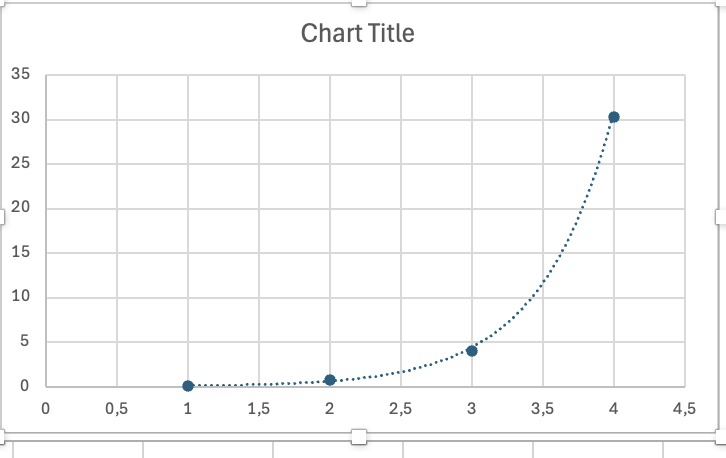

In [2]:
from IPython.display import Image
Image("trendline.png")

9.2. Problemy

Znalezienie odpowiedniej funkcji heurystycznej, która dobrze przewidywałaby końcowy wynik gry, było trudne. Testowano różne podejścia, ale najlepsze wyniki osiągnięto dla kombinacji heurystyk mobilności i kontroli centrum.

Dla większych plansz i głębokości przeszukiwania czas wykonania algorytmu stawał się nieakceptowalnie długi. Problem został częściowo rozwiązany przez implementację cięć alfa-beta, ale dla głębokości większych niż 5-6 na standardowej planszy 5×6 czas wykonania nadal był znaczący. Próbowano liczyć na planszy 10x10, ale czas był nieakceptowalny.

9.3 Wnioski

Zaimplementowany algorytm Minimax z cięciami alfa-beta skutecznie znajduje optymalne ruchy w grze Clobber dla ograniczonej głębokości przeszukiwania. Jakość gry jest silnie zależna od zastosowanej funkcji heurystycznej. I tak na prawdę cała zabawa polega na wymyśleniu i opracowaniu dobrej funkcji heurystycznej. W moim przypadku, najlepszą heurystyką okazałą się heurystyka oparta na kontroli centralnych pól. Z coraz większą głębokością, ta heurystyka zwiększała swoją dominacje nad innymi.